In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import misc_data_utils

In [17]:
# Could not get data for: ESNT, ATVI
data = misc_data_utils.get_data(source="russell", size=1500, start="2020-04-01", interval='1h')

Using 1500 symbols
Changing symbol GEF.B to GEF-B
Changing symbol CRD.B to CRD-B
Changing symbol LGF.A to LGF-A
Changing symbol HEI.A to HEI-A
Changing symbol LEN.B to LEN-B
Changing symbol LGF.B to LGF-B
Changing symbol BRK.B to BRK-B
[*********************100%***********************]  1500 of 1500 completed


In [18]:
# Convert prices to percent change
raw_data = data["Adj Close"].pct_change().values[1:]

# Clean and transform data for modeling
sequences = misc_data_utils.clean_data(raw_data)
train_sequences, test_sequences = misc_data_utils.train_test_split(sequences, test_size=0.15)

# slice sequences for input-output relationtip with lagged price data as input
x_train, y_train = misc_data_utils.slice_sequences(train_sequences, classification=True)
x_test, y_test = misc_data_utils.slice_sequences(test_sequences, classification=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2722771, 10), (2722771,), (477751, 10), (477751,))

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [23]:
layers = [
    Dense(64, activation='relu'), 
    Dense(64, activation='relu'), 
    
    Dense(64, activation='relu'), 
    Dense(64, activation='relu'),
    
    Dense(64, activation='relu'), 
    Dense(64, activation='relu'),
    
    Dense(1, activation='sigmoid')
]

model = Sequential(layers)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['acc'])

In [24]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=40, 
    batch_size=4096 * 4, 
    validation_data=(x_test, y_test))

Epoch 1/40
167/167 [==============================] - 23s 138ms/step - loss: 0.6927 - acc: 0.5137 - val_loss: 0.6922 - val_acc: 0.5197
Epoch 2/40
167/167 [==============================] - 23s 135ms/step - loss: 0.6920 - acc: 0.5202 - val_loss: 0.6918 - val_acc: 0.5213
Epoch 3/40
167/167 [==============================] - 22s 133ms/step - loss: 0.6915 - acc: 0.5221 - val_loss: 0.6911 - val_acc: 0.5252
Epoch 4/40
167/167 [==============================] - 24s 142ms/step - loss: 0.6911 - acc: 0.5246 - val_loss: 0.6912 - val_acc: 0.5230
Epoch 5/40
167/167 [==============================] - 23s 136ms/step - loss: 0.6908 - acc: 0.5252 - val_loss: 0.6905 - val_acc: 0.5265
Epoch 6/40
167/167 [==============================] - 22s 131ms/step - loss: 0.6904 - acc: 0.5263 - val_loss: 0.6908 - val_acc: 0.5250
Epoch 7/40
167/167 [==============================] - 22s 134ms/step - loss: 0.6899 - acc: 0.5267 - val_loss: 0.6923 - val_acc: 0.5157
Epoch 8/40
167/167 [==============================] - 2

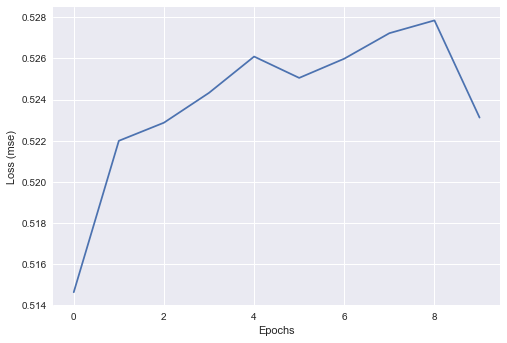

In [22]:
plt.plot(history.history["val_acc"])
plt.xlabel("Epochs")
plt.ylabel("Loss (mse)")
plt.show()